In [ ]:
# EDA: Statistical summaries and univariate distributions for claims_train.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textwrap import dedent
from caas_jupyter_tools import display_dataframe_to_user

ModuleNotFoundError: No module named 'caas_jupyter_tools'

In [2]:
df = pd.read_csv("./data/claims_train.csv")


info_table = pd.DataFrame({
    "n_rows": [len(df)],
    "n_cols": [df.shape[1]],
    "n_numeric": [df.select_dtypes(include=[np.number]).shape[1]],
    "n_categorical": [df.select_dtypes(exclude=[np.number]).shape[1]],
    "missing_total": [df.isna().sum().sum()]
})

info_table

,n_rows,n_cols,n_numeric,n_categorical,missing_total
0,542410,12,8,4,0


In [3]:
# Missingness by column
missing_by_col = df.isna().sum().rename("missing_count").to_frame()
missing_by_col["missing_pct"] = (missing_by_col["missing_count"] / len(df)).round(6)

In [4]:
# Summary stats (numeric + categorical)
summary_numeric = df.describe().T
summary_categorical = df.describe(include="object").T

In [5]:
# Show tables to user
display_dataframe_to_user("Dataset info", info_table)
display_dataframe_to_user("Missingness by column", missing_by_col)
display_dataframe_to_user("Numeric summary (describe)", summary_numeric)
display_dataframe_to_user("Categorical summary (describe)", summary_categorical)


NameError: name 'display_dataframe_to_user' is not defined

In [8]:
# Claim occurrence (binary)
df["ClaimOccur"] = (df["ClaimNb"] > 0).astype(int)

# Claim rate per year (handle Exposure == 0 safely)
df["ClaimRate"] = np.where(df["Exposure"] > 0, df["ClaimNb"] / df["Exposure"], np.nan)

In [9]:
# Helper plotting functions

def hist_plot(series, bins=50, title="", xlabel="", xlim=None, logy=False):
    plt.figure(figsize=(7, 4))
    plt.hist(series.dropna().values, bins=bins)
    if xlim is not None:
        plt.xlim(xlim)
    if logy:
        plt.yscale("log")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def bar_topn(series, topn=20, title="", xlabel="Category", ylabel="Count", rotate=45):
    counts = series.value_counts().head(topn)
    plt.figure(figsize=(8, 4))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotate, ha="right")
    plt.tight_layout()
    plt.show()

Target variables

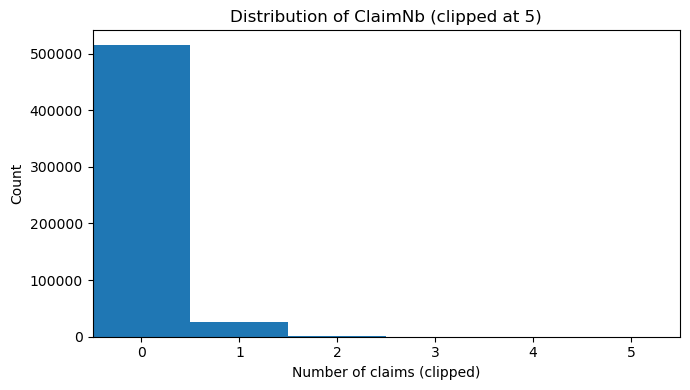

In [12]:
# ClaimNb distribution (clip x-axis for readability)
max_claim_cap = 5  # visualize up to 5 claims; very few beyond that
hist_plot(
    series=df["ClaimNb"].clip(upper=max_claim_cap),
    bins=np.arange(-0.5, max_claim_cap + 1.5, 1),
    title="Distribution of ClaimNb (clipped at 5)",
    xlabel="Number of claims (clipped)",
    xlim=(-0.5, max_claim_cap + 0.5),
    logy=False
)

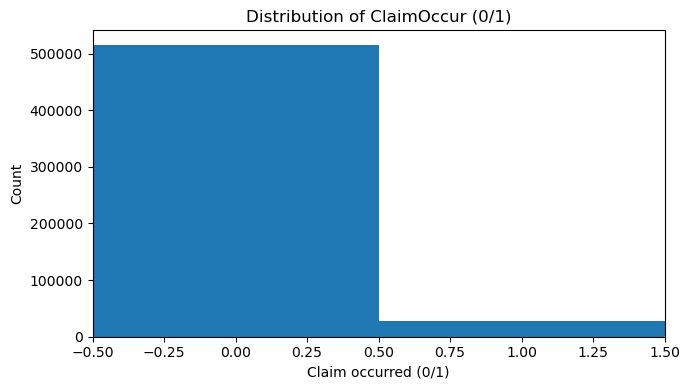

In [11]:
# Claim occurrence rate
hist_plot(
    series=df["ClaimOccur"],
    bins=np.arange(-0.5, 2, 1),
    title="Distribution of ClaimOccur (0/1)",
    xlabel="Claim occurred (0/1)",
    xlim=(-0.5, 1.5),
    logy=False
)

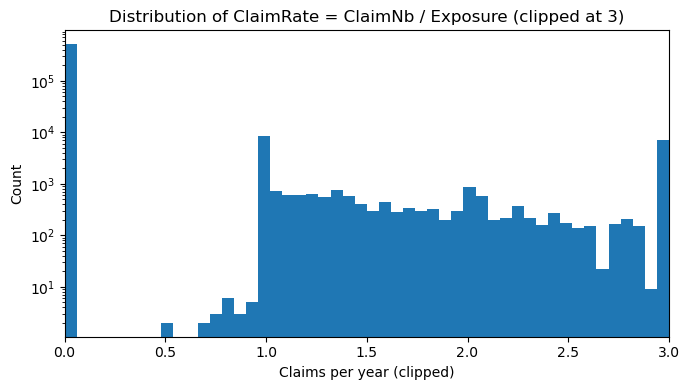

In [16]:

# ClaimRate distribution (clip extreme rates for visibility)
rate_clip = df["ClaimRate"].dropna().clip(upper=3)  # cap extreme outliers
hist_plot(
    series=rate_clip,
    bins=50,
    title="Distribution of ClaimRate = ClaimNb / Exposure (clipped at 3)",
    xlabel="Claims per year (clipped)",
    xlim=(0, 3),
    logy=True  # often heavy tail
    )

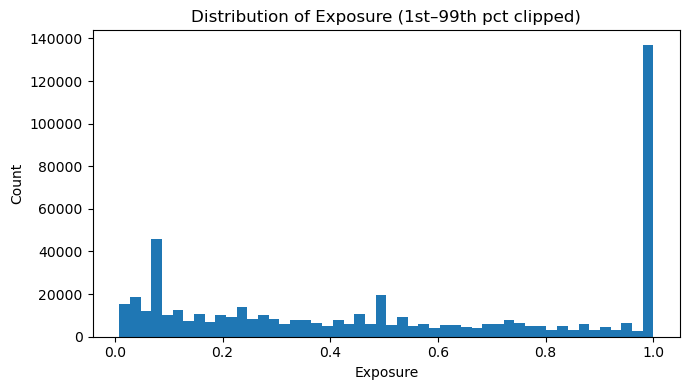

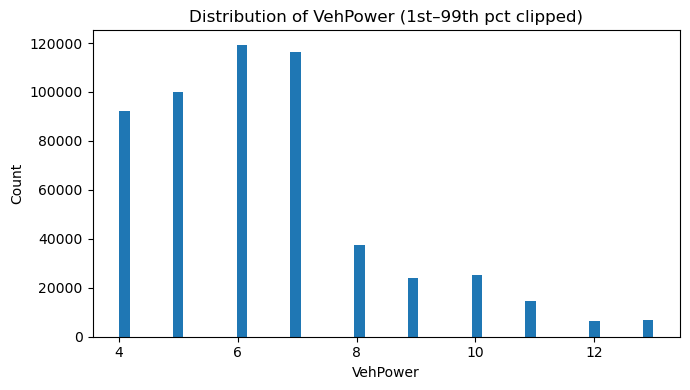

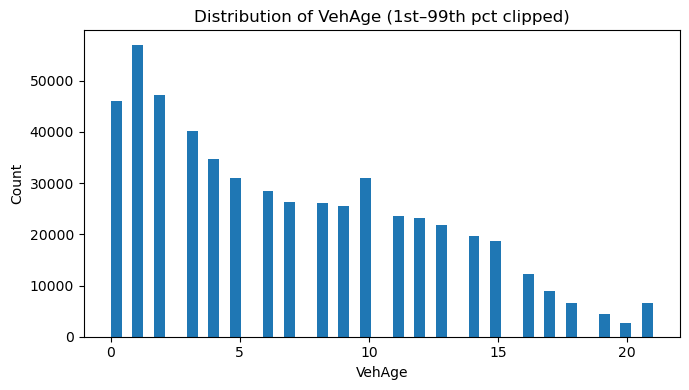

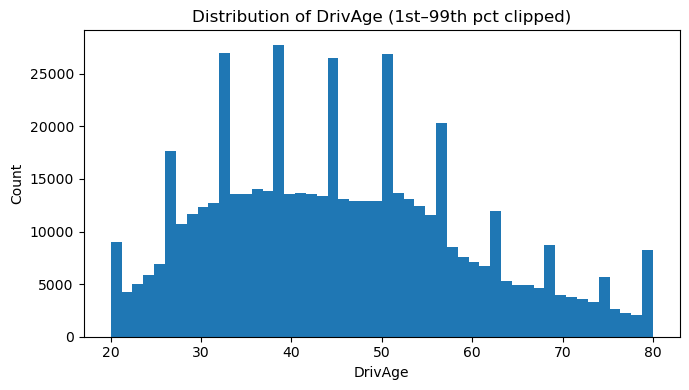

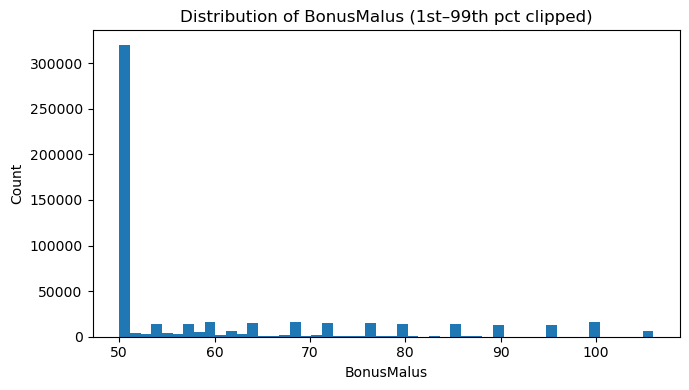

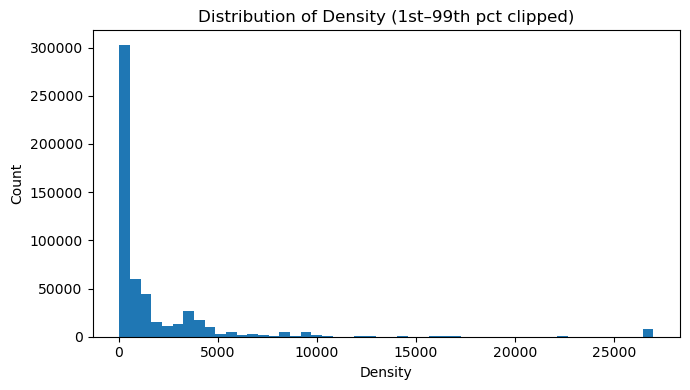

In [17]:
# Numeric feature distributions
numeric_cols = ["Exposure", "VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]

for col in numeric_cols:
    # sensible caps for visibility
    series = df[col].astype(float)
    # dynamic clipping: cap at 99th percentile for readability
    upper = np.nanpercentile(series, 99)
    lower = np.nanpercentile(series, 1)
    clipped = series.clip(lower=lower, upper=upper)
    hist_plot(
        series=clipped,
        bins=50,
        title=f"Distribution of {col} (1st–99th pct clipped)",
        xlabel=col,
        logy=False
    )

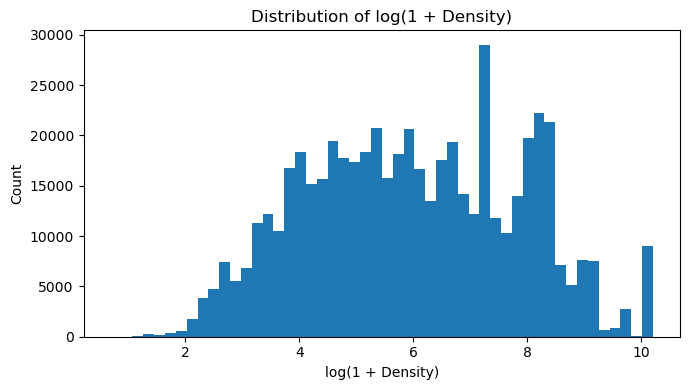

In [18]:
# log-scale density to show long tail structure
density_pos = df.loc[df["Density"] > 0, "Density"].astype(float)
hist_plot(
    series=np.log1p(density_pos),
    bins=50,
    title="Distribution of log(1 + Density)",
    xlabel="log(1 + Density)",
    logy=False
)

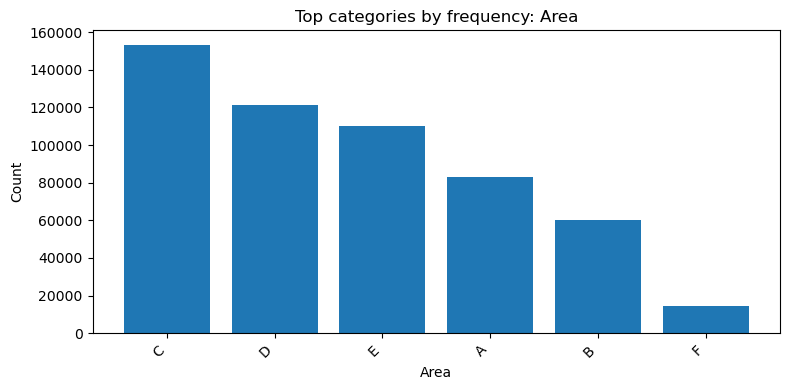

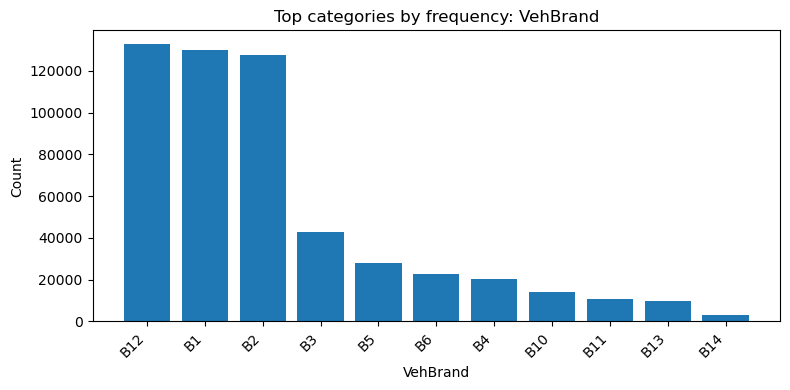

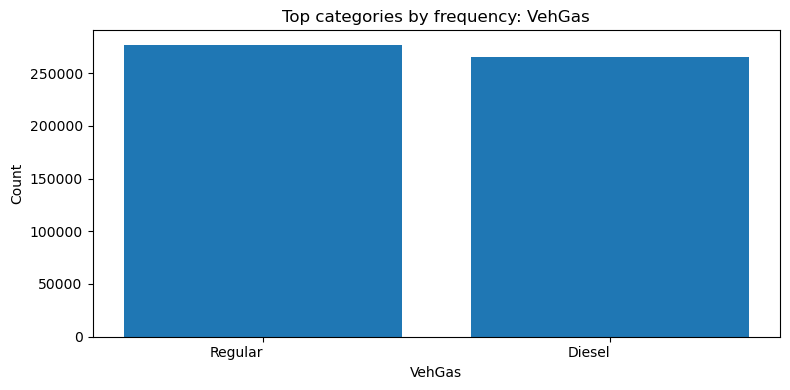

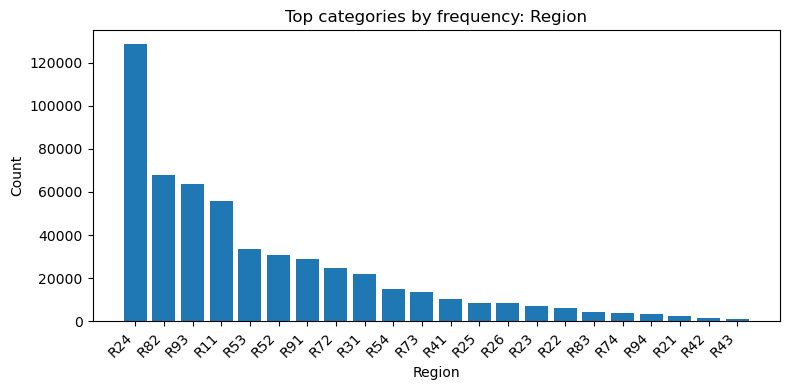

In [ ]:
#Categorical feature frequencies
categorical_cols = ["Area", "VehBrand", "VehGas", "Region"]

for col in categorical_cols:
    bar_topn(
        series=df[col].astype(str),
        topn=50 if col == "Region" else 20,  # Region has many levels
        title=f"Top categories by frequency: {col}",
        xlabel=col,
        ylabel="Count",
        rotate=0 if col in ["VehGas"] else 45
    )

In [21]:
# Export a compact EDA summary report (CSV)
# -----------------------------
compact_summary = pd.DataFrame({
    "feature": df.columns,
    "dtype": [df[c].dtype for c in df.columns],
    "n_unique": [df[c].nunique() for c in df.columns],
    "n_missing": [df[c].isna().sum() for c in df.columns]
})
compact_path = "./data/eda_compact_summary.csv"
compact_summary.to_csv(compact_path, index=False)